In [1]:
# !pip install scikit-uplift catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.metrics import uplift_at_k, uplift_by_percentile
from sklift.viz import plot_uplift_preds, plot_qini_curve, plot_uplift_by_percentile
from sklift.viz.base import qini_auc_score
from sklift.models import SoloModel, TwoModels, ClassTransformation

### **1. скачать набор данных маркетинговых кампаний [отсюда](https://www.kaggle.com/davinwijaya/customer-retention)**
### **2. поле ```conversion``` - это целевая переменная, а ```offer``` - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.**
### **3. сделать разбиение набора данных не тренировочную и тестовую выборки**
### **4. провести uplift-моделирование 3 способами:**
1. **одна модель с признаком коммуникации (S-learner)**
2. **модель с трансформацией таргета**
3. **вариант с двумя независимыми моделями**

### **5. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей**

Качаем и подгружаем датасет:

In [3]:
# !wget 'https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ' -O data.csv

In [4]:
df = pd.read_csv('data.csv', sep=',')

In [5]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,64000.0,5.763734,3.507592,1.00,2.00,6.00,9.0000,12.00
history,64000.0,242.085656,256.158608,29.99,64.66,158.11,325.6575,3345.93
used_discount,64000.0,0.551031,0.497393,0.00,0.00,1.00,1.0000,1.00
used_bogo,64000.0,0.549719,0.497526,0.00,0.00,1.00,1.0000,1.00
is_referral,64000.0,0.502250,0.499999,0.00,0.00,1.00,1.0000,1.00
conversion,64000.0,0.146781,0.353890,0.00,0.00,0.00,0.0000,1.00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


что имеем:
- **```recency```** - новизна. Сколько меяцев прошло с момента последней покупки. Пропусков нет, а значения от до 

In [8]:
np.sort(df.recency.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

- **```history```** - история стоимости заказов, тип float, вот распределение:

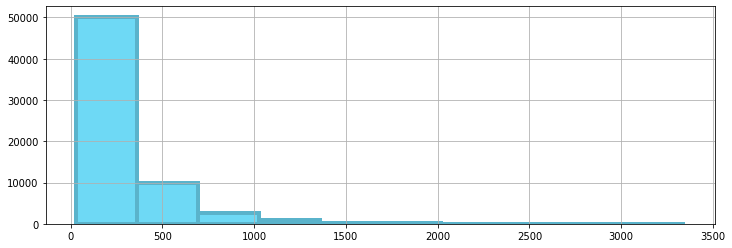

In [9]:
df.history.hist(figsize=(12, 4), color='#6ED9F5', edgecolor='#5AB3CB', lw=4);

- **```used_discount```** - использовал ли скидку раньше. Бинарный признак

In [10]:
df.used_discount.value_counts()

1    35266
0    28734
Name: used_discount, dtype: int64

- **```used_bogo```** - флаг, определяющий, использовал ли клиент акцией второго товара в подарок "Buy One Get One". Бинарный признак




In [11]:
df.used_bogo.value_counts()

1    35182
0    28818
Name: used_bogo, dtype: int64

- **```zip_code```** - класс почтового индекса как пригородный / городской / сельский. Категориальный признак

In [12]:
df.zip_code.value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

- **```is_referral```** - был ли клиент привлечен по реферальному каналу. Бинарный признак

In [13]:
df.is_referral.value_counts()

1    32144
0    31856
Name: is_referral, dtype: int64

- **```channel```** - каналы, которые использует клиент, телефон/веб/многоканальный. Категориальный признак

In [14]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

- **```offer```** - предложения, отправленные клиентам, скидка / второй товар в подарок / нет предложения. Категориальный признак

In [15]:
df.offer.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

- **```conversion```** - конверсия клиента - купил или нет. Бинарный признак, целевая переменная

In [16]:
df.conversion.value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

- **```channel```** - канал коммуникации. Категориалльный признак

In [17]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

Итого у нас признаки:
- **бинарные признаки** - used_discount, used_bogo, is_referral, channel, conversion
- **числовые**- recency, history
- **категориальные признаки** - zip_code, channel, offer

Переименуем поля (```conversion``` -> ```target```, ```offer``` -> ```treatment```) и приведём поле ```treatment``` к бинарному виду (1 или 0, т.е было какое-то предложение или нет):

In [18]:
df = df.rename(columns={'offer': 'treatment', 'conversion': 'target'})
df.columns.tolist()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'treatment',
 'target']

In [19]:
# меняем treatment:
df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}, inplace=True)
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

разбиение набора данных на тренировочную и тестовую выборки, uplift-моделирование 3 способами и сбор данных для единой таблицы для сравнения метрик *uplift@10%*, *uplift@20%* трёх (на самом деле четырёх) моделей напишем в классе, а для классификации будем использовать алгоритм ```CatBoostClassifier```

In [20]:
class UpliftTrainTestSplitter:

    def __init__(self, df):
        self.df = df
        self.X_train, self.X_test, self.treat_train = None, None, None
        self.y_train, self.y_test, self.treat_val = None, None, None
        self.trmnt_preds, self.ctrl_preds = None, None  # P(T), P(C)
        self.name = None
        self.score_10 = None
        self.score_20 = None
        self.test_size = None
        self.uplift_model = None

    def train_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = (
            train_test_split(self.df.drop(columns='target'),
                             self.df['target'], test_size=self.test_size,
                             random_state=42, stratify=self.df['target']))
        self.treat_train = self.X_train['treatment']
        self.X_train.drop(columns=['treatment'], inplace=True)
        self.treat_val = self.X_test['treatment']
        self.X_test.drop(columns='treatment', inplace=True)

    def get_metric(self):
        return pd.DataFrame({'model': [self.name],
                             'uplift@10%': [self.score_10],
                             'uplift@20%': [self.score_20]})

    def get_plot_uplift_preds(self):
        try:
            plot_uplift_preds(trmnt_preds=self.trmnt_preds,
                              ctrl_preds=self.ctrl_preds);
        except:
            print(f'модель {self.name} не поддерживает plot_uplift_preds')

    def get_qini_qurve(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        plot_qini_curve(self.y_test, self.uplift_model, self.treat_val,
                        perfect=False, ax=ax)
        print(f'qini_auc_score = {qini_auc_score(self.y_test, self.uplift_model, self.treat_val):.4f}')


class ModelGeneration(UpliftTrainTestSplitter):
    def __init__(self, df, model, cat_features=[], method='ddr_treatment'):
        super().__init__(df)
        self.df = df
        model_args = {'iterations': 20, 'random_state': 42, 'silent': True,
                      'cat_features': cat_features}
        if model == 'sm':
            self.model = SoloModel(CatBoostClassifier(**model_args))
        elif model == 'ct':
            self.model = ClassTransformation(CatBoostClassifier(**model_args))
        elif model == 'tm':
            self.model = tm = TwoModels(
                CatBoostClassifier(**model_args),
                CatBoostClassifier(**model_args),
                method=method)
        else:
            raise ValueError('аргумент "model" инвалид')

    def fit_predict(self, get_predict=False):
        self.model = self.model.fit(self.X_train, self.y_train, self.treat_train)
        self.uplift_model = self.model.predict(self.X_test)
        if get_predict:
            return self.uplift_model

        sm_score_10 = uplift_at_k(y_true=self.y_test, uplift=self.uplift_model,
                                  treatment=self.treat_val, strategy='by_group', k=0.1)
        sm_score_20 = uplift_at_k(y_true=self.y_test, uplift=self.uplift_model,
                                  treatment=self.treat_val, strategy='by_group', k=0.2)

        self.name = type(self.model).__name__
        self.score_10 = sm_score_10
        self.score_20 = sm_score_20
        try:
            self.trmnt_preds = self.model.trmnt_preds_  # P(T)
            self.ctrl_preds = self.model.ctrl_preds_   # P^(C)
        except:
            pass

In [21]:
cat_features = ['zip_code', 'channel']

,model,uplift@10%,uplift@20%
0,SoloModel,0.099072,0.088734


qini_auc_score = 0.0349


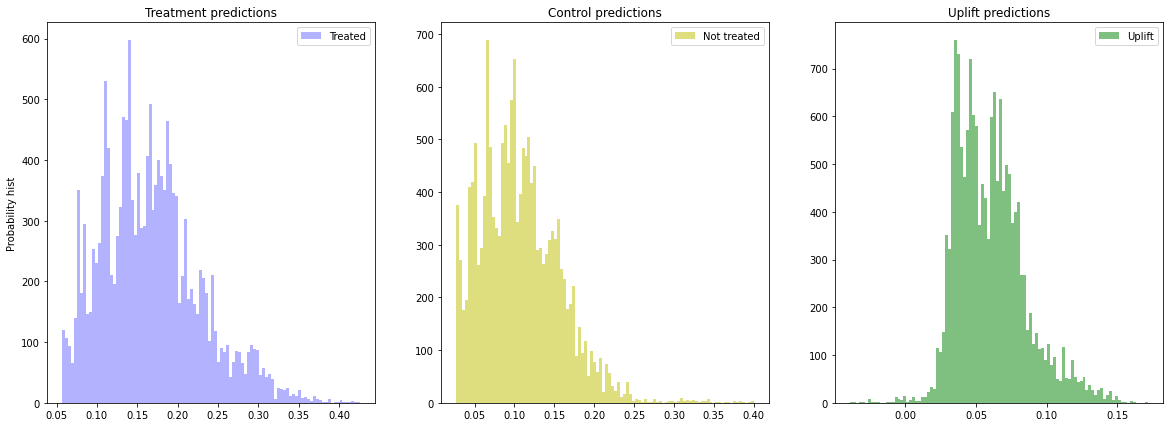

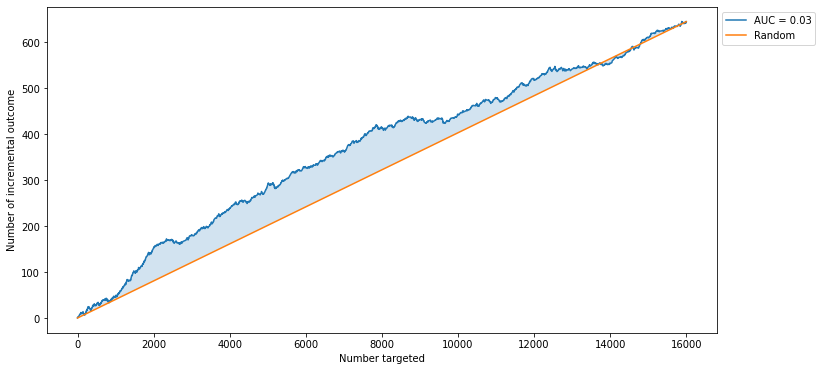

In [22]:
sm = ModelGeneration(df, model='sm', cat_features=cat_features)
sm.train_test()
sm.fit_predict()
metrics_sm = sm.get_metric()
display(metrics_sm)
sm.get_plot_uplift_preds()
sm.get_qini_qurve()

,model,uplift@10%,uplift@20%
0,ClassTransformation,0.091272,0.082507


qini_auc_score = 0.0098


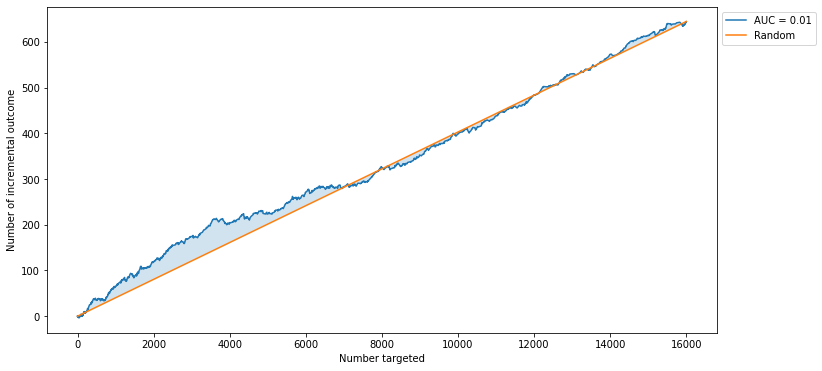

In [23]:
ct = ModelGeneration(df, model='ct', cat_features=cat_features)
ct.train_test()
ct.fit_predict()
metrics_ct = ct.get_metric()
display(metrics_ct)
# ct.get_plot_uplift_preds()
ct.get_qini_qurve()

,model,uplift@10%,uplift@20%
0,TwoModels,0.099305,0.092207


qini_auc_score = 0.0315


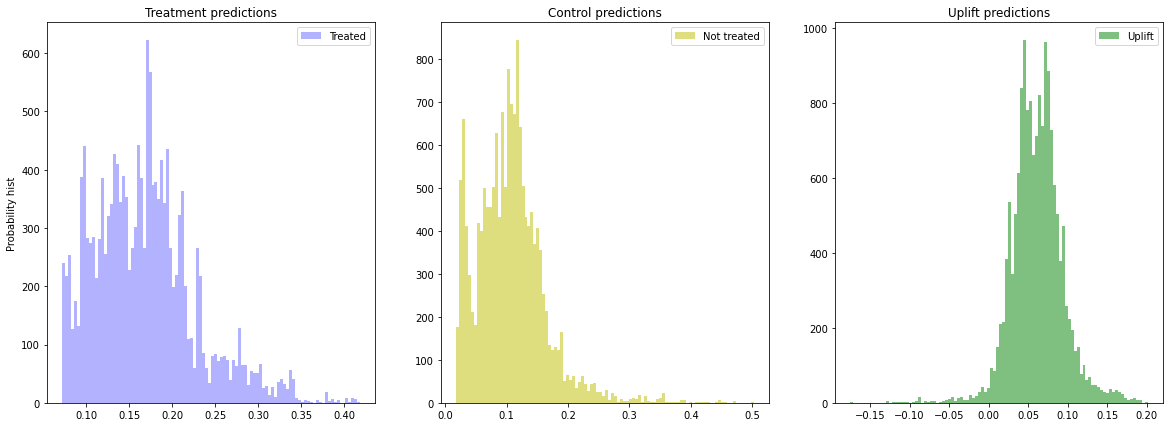

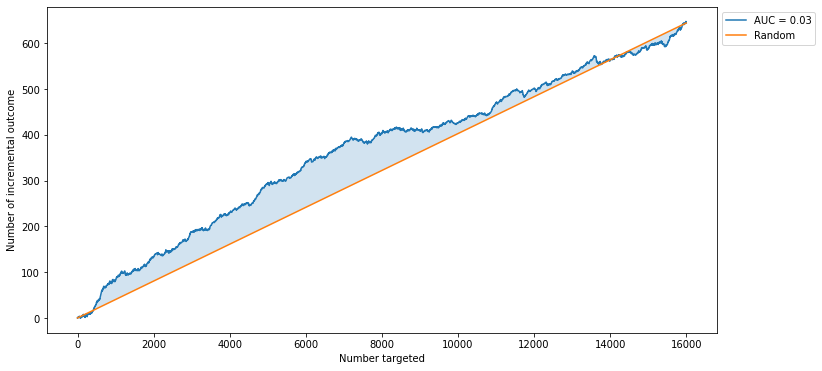

In [24]:
tm = ModelGeneration(df, model='tm', cat_features=cat_features)
tm.train_test()
tm.fit_predict()
metrics_tm_ddr = tm.get_metric()
display(metrics_tm_ddr)
tm.get_plot_uplift_preds()
tm.get_qini_qurve()

,model,uplift@10%,uplift@20%
0,TwoModels,0.104,0.07436


qini_auc_score = 0.0218


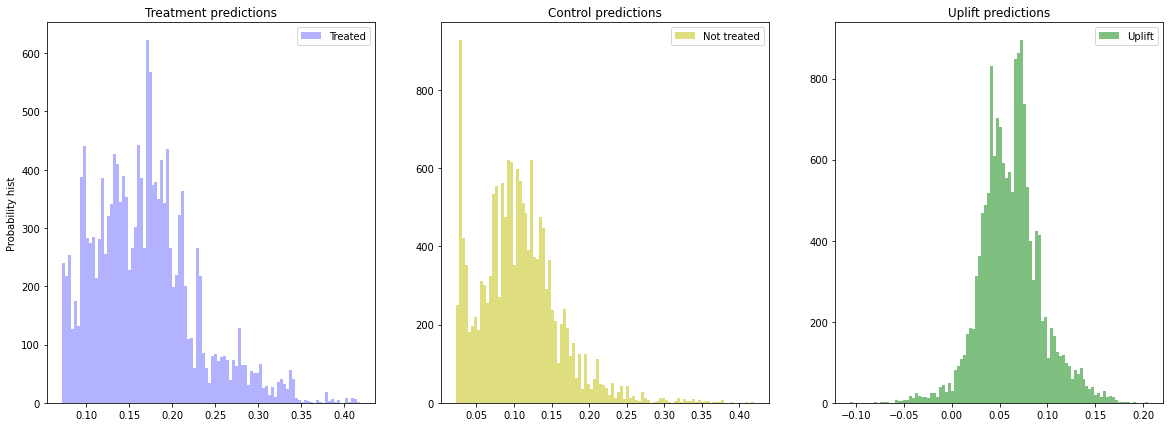

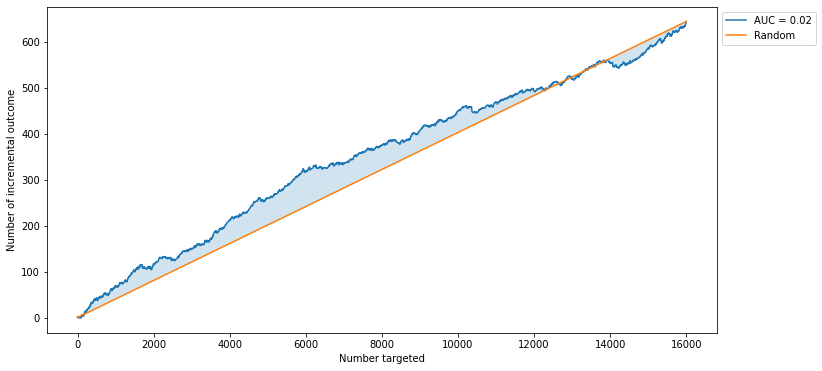

In [25]:
tm = ModelGeneration(df, model='tm', method='vanilla', cat_features=cat_features)
tm.train_test()
tm.fit_predict()
metrics_tm_vanilla = tm.get_metric()
display(metrics_tm_vanilla)
tm.get_plot_uplift_preds()
tm.get_qini_qurve()

In [26]:
metrics_tm_ddr['model'] = 'TwoModels_ddr'
metrics_tm_vanilla['model'] = 'TwoModels_vanilla'

In [27]:
(
    pd.concat([metrics_sm, metrics_ct, metrics_tm_ddr, metrics_tm_vanilla],
              axis=0).reset_index(drop=True).round(4)
)

,model,uplift@10%,uplift@20%
0,SoloModel,0.0991,0.0887
1,ClassTransformation,0.0913,0.0825
2,TwoModels_ddr,0.0993,0.0922
3,TwoModels_vanilla,0.1040,0.0744


на 10%-x лучшие показатели у TwoModels_vanilla, но мы знаем, что при vanilla применяются две независимые модели и их вероятности никак не согласовываны друг с другом, так что лучше ориентироваться на показатели моделей TwoModels_ddr и SoloModel, они отличаются совсем несущественно друг от друга

а на 20%-x лучшие показатели у модели TwoModels_ddr и если маркетинговый бюджет позволяет, то лучше пользоваться ей


### **6. *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:**
1. **сделать прогноз и получить uplift для тестовой выборки**
2. **отсортировать тестовую выборку по uplift по убыванию**
3. **разбить на децили (pandas qcut вам в помощь)**
4. **для каждого дециля посчитать среднюю conversion**

In [28]:
# создадим Solo-модель и обучим её:
target_dependency = ModelGeneration(df, model='sm', cat_features=cat_features)
target_dependency.train_test()
target_dependency.fit_predict()

In [29]:
# предсказанные значения uplift:
target_dependency.uplift_model

array([0.06209474, 0.04263661, 0.06722081, ..., 0.046338  , 0.07060705,
       0.14446538])

In [30]:
# тестовая выборка
X_test = target_dependency.X_test
# добавим в неё uplift и признак conversion (y_test):
X_test['uplift'] = target_dependency.uplift_model
X_test['conversion'] = target_dependency.y_test
# отсортируем тестовую выборку по убыванию значений uplift
X_test = X_test.sort_values(by='uplift', ascending=False)

# pd.qcut() разбивает непрерывный числовой столбец на категории на основе квантилей данных.
# Он позволяет разбить данные на равные по количеству элементов группы
# разбьём выборку с помощью pd.qcut() на децили:

X_test['deciles'] = pd.qcut(X_test['uplift'], q=10, labels=False)

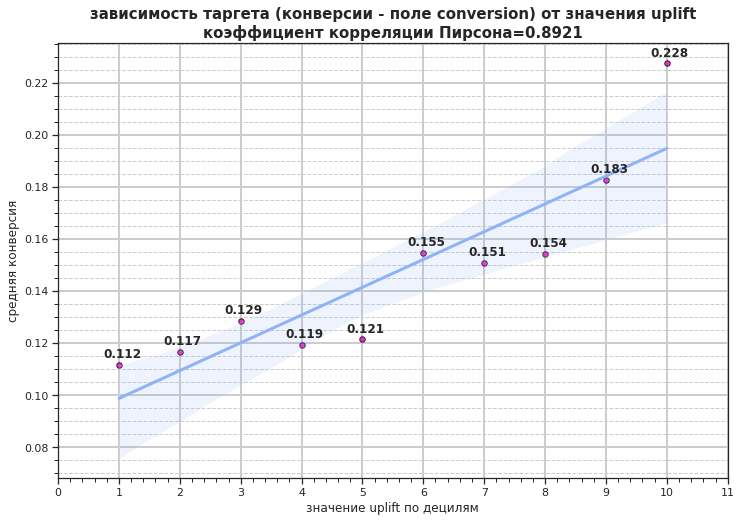

In [31]:
plt.figure(figsize=(12, 8))
sns.set(style='ticks', palette='pastel')

x = np.sort(X_test['deciles'].unique())
y = [X_test.loc[X_test['deciles'] == i, 'conversion'].mean() for i in range(0, 10)]

sns.regplot(x=x, y=y,
            scatter_kws={'s': 30, 'color': '#F700D6', 'edgecolors': '#000000'},
            line_kws={'color': '#8EB3F7', 'lw': 3});
for i in np.sort(X_test['deciles'].unique()):
    plt.annotate(round(X_test.loc[X_test['deciles'] == i, 'conversion'].mean(), 3),
                 xy=(i, X_test.loc[X_test['deciles'] == i, 'conversion'].mean()),
                 xytext=(-16, 7), textcoords='offset points', fontweight='bold')
plt.xticks(range(-1, 11), range(0, 12))
plt.xlabel('значение uplift по децилям')
plt.ylabel('средняя конверсия')
plt.title(f'зависимость таргета (конверсии - поле conversion) от значения uplift\n'\
          f'коэффициент корреляции Пирсона={np.corrcoef(x,y)[0, 1]:.4f}',
          fontweight='bold', fontsize=15)
plt.minorticks_on()
plt.grid(which='major', linewidth=2)
plt.grid(which='minor', axis='y', linestyle='--');

$\Rightarrow$ зависимость прямая - там, где высокий uplift, высокая и конверсия